<a href="https://colab.research.google.com/github/leti-olabarri/drunk-chatbot/blob/develop/models/Basic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(/)([0-9]+)(/)([0-9][0-9]) ([0-9]+):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):   
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    splitMessage = message.split(': ')
    author = splitMessage[0]
    message = ' '.join(splitMessage[1:])
    return date, time, author, message

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
### Uploading exported chat file
conversationPath = '../content/drive/MyDrive/data/all.txt' # chat file
with open(conversationPath, encoding="utf-8") as fp:
    ### Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip()
        if startsWithDateAndTime(line):
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear()
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
### changing datatype of "Date" column.
df["Date"] = pd.to_datetime(df["Date"])
df["Time"] = pd.to_datetime(df["Time"], format='%H%M', errors='ignore')

In [3]:
df.drop(df[(df['Author'] == 'Los mensajes y las llamadas están cifrados de extremo a extremo. Nadie fuera de este chat, ni siquiera WhatsApp, puede leerlos ni escucharlos. Toca para obtener más información.')].index, inplace=True)
df.drop(df[(df['Author'] == '\u200eMarcela Duque cambió su número de teléfono. Toca para enviar un mensaje o añadir el nuevo número.')].index, inplace=True)
df.drop(df[(df['Author'] == '\u200eMarcela Duque cambió su número de teléfono. Actualmente te estás comunicando con su nuevo número. Toca para añadir a tus contactos.')].index, inplace=True)
df.drop(df[(df['Message'] == '<Multimedia omitido>')].index, inplace=True)

In [4]:
df.head()

,Date,Time,Author,Message
0,2019-12-20,21:17,Leticia Olábarri,Adri
1,2019-12-20,21:17,Leticia Olábarri,¿Vienes?
2,2019-12-20,22:02,Adri Ávalos,Sí 😬
3,2019-12-20,22:03,Adri Ávalos,Ya voy
4,2019-12-20,22:03,Adri Ávalos,Me he liado un pelin


In [5]:
def transform_names(name):
    if name == "Leticia Olábarri":
        return 1
    else:
        return 0

df["Author"] = df["Author"].apply(transform_names)

In [6]:
df.head()

,Date,Time,Author,Message
0,2019-12-20,21:17,1,Adri
1,2019-12-20,21:17,1,¿Vienes?
2,2019-12-20,22:02,0,Sí 😬
3,2019-12-20,22:03,0,Ya voy
4,2019-12-20,22:03,0,Me he liado un pelin


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["Message"], df["Author"], test_size=0.2, random_state=42)

In [8]:
labels = y_train.unique()
labels

array([0, 1])

In [9]:
max_features = 10000
sequence_length = 1000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [10]:
vectorize_layer.adapt(X_train)

In [11]:
train_ds = vectorize_layer(X_train)
test_ds = vectorize_layer(X_test)

In [12]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

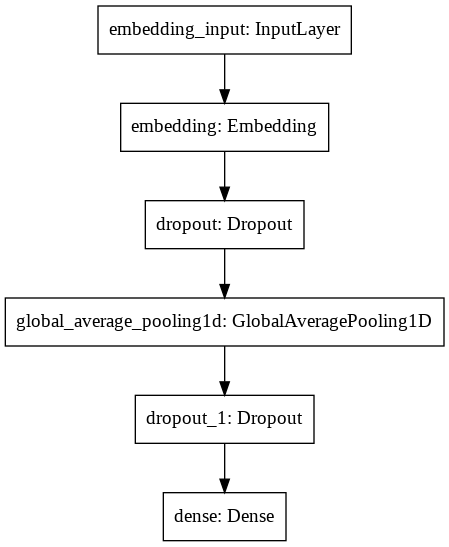

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
print(len(train_ds))
print(len(test_ds))

44005
11002


In [ ]:
epochs = 20
history = model.fit(
    train_ds,y_train,
    validation_data= (test_ds, y_test),
    epochs=epochs)

Epoch 1/20
1376/1376 [==============================] - 21s 14ms/step - loss: 0.6929 - binary_accuracy: 0.5087 - val_loss: 0.6924 - val_binary_accuracy: 0.6239
Epoch 2/20
1376/1376 [==============================] - 19s 14ms/step - loss: 0.6917 - binary_accuracy: 0.5285 - val_loss: 0.6907 - val_binary_accuracy: 0.5215
Epoch 3/20
1376/1376 [==============================] - 19s 14ms/step - loss: 0.6894 - binary_accuracy: 0.5529 - val_loss: 0.6904 - val_binary_accuracy: 0.5088
Epoch 4/20
1376/1376 [==============================] - 19s 14ms/step - loss: 0.6853 - binary_accuracy: 0.5792 - val_loss: 0.6832 - val_binary_accuracy: 0.5911
Epoch 5/20
1376/1376 [==============================] - 19s 14ms/step - loss: 0.6791 - binary_accuracy: 0.6035 - val_loss: 0.6747 - val_binary_accuracy: 0.6283
Epoch 6/20
1376/1376 [==============================] - 19s 14ms/step - loss: 0.6697 - binary_accuracy: 0.6229 - val_loss: 0.6662 - val_binary_accuracy: 0.6694
Epoch 7/20
1376/1376 [==================

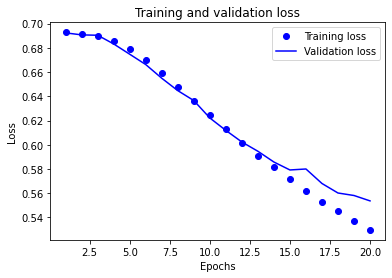

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

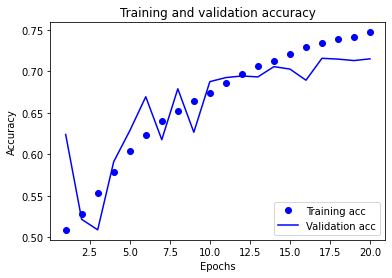

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model.save("basic_classification.h5")

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "¿Cómo te encuentras hoy?"
]

export_model.predict(examples)

array([[0.11343548],
       [0.14677629],
       [0.7800406 ]], dtype=float32)

In [ ]:
export_model.save("export_basic_classification")

INFO:tensorflow:Assets written to: export_basic_classification/assets


In [ ]:
new_model = tf.keras.models.load_model('export_basic_classification')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 160033    
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
